# Fundamental Law of Memory Recall 



In [6]:
!sudo apt-get install texlive-full  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aglfn asymptote asymptote-doc biber chktex cm-super cm-super-minimal context
  context-modules dvidvi dvipng emacsen-common feynmf fonts-adf-accanthis
  fonts-adf-berenis fonts-adf-gillius fonts-adf-universalis
  fonts-arphic-bkai00mp fonts-arphic-bsmi00lp fonts-arphic-gbsn00lp
  fonts-arphic-gkai00mp fonts-baekmuk fonts-cabin fonts-comfortaa
  fonts-croscore fonts-crosextra-caladea fonts-crosextra-carlito
  fonts-dejavu-core fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-baskerville
  fonts-gfs-bodoni-classic fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-didot-classic fonts-gfs-gazis fonts-gfs-neohellenic fonts-gfs-olga
  fonts-gfs-porson fonts-gfs-solomos fonts-gfs-theokritos fonts-go
  fonts-hosny-amiri fonts-i

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import scipy
from matplotlib import cm
import random
import heapq
from collections import Counter

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Item representations are chosen as random binary $\{0,1\}$ vectors where each element of the vector chosen to be 1 with small probability $f \ll 1$ independently of other elements.
Overlaps are defined as scalar products between these
representations.

The proposed recall process is based on two principles:

1. memory items are represented in the brain by overlapping random sparse neuronal ensembles in dedicated memory networks;
2. the next item to be recalled is the one with a largest overlap to the current one, excluding the item that was recalled on the previous step.

Pseudocode:
- find the second largest value in the first row of SM
- go to the row corresponding to its column index
- iterate 


In [8]:
def BuildItems(L, N, f): 
    """
    L = number of items
    N = number of neurons
    f = probability of a neuron to be 1
    """
    #np.random.seed(5)
    return np.random.choice([0, 1], size=(L, N), p=[1-f, f])

def SimilarityMatrix(items):
    sim = cosine_similarity(items, dense_output=True)
    # change the diagonal elements from 0 to 1 so that it does not interfere when we are
    # searching for the maximum element in a row
    np.fill_diagonal(sim, 0)
    return sim 

def PlotSM(sim, L):
    sns.set_context({"figure.figsize": (12, 12)})
    sns.set_style("white")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Blues', 20)
    cmap.set_bad('w') # default value is 'k'
    ax1.imshow(sim, cmap=cmap)
    #plt.ylabel("Cluster", size = 16)
    #plt.xlabel("Cluster", size = 16)
    sns.despine()
    plt.colorbar(ax1.matshow(sim, cmap=cmap, vmin=0, vmax=1), shrink=.75)
    ax1.xaxis.set_label_position('bottom')
    ax1.xaxis.set_ticks_position('bottom')
    plt.xticks(range(0,L,1), size = 16)
    plt.yticks(range(0,L,1), size = 16)
    #plt.savefig('similarity_matrix.pdf', dpi=220, bbox_inches='tight')

def memory_recall_process_OLD(L, N, f):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    # starting point: find the largest element in the first row
    recall_list = [None]*(L+1)
    recall_list[0] = np.where(sim[0, ] == sim[0, ].max())[0][0]
    for i in range(L):
        # find the largest element in a row
        recall_list[i+1] = np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0]
        # if the process points to an item that was just recalled in the previous step,
        # select the next largest overlap 
        if recall_list[i+1] == recall_list[i]:
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
    R = len(set(recall_list))
    return R

In [9]:
def memory_recall_process(L, N, f):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    recall_list = [None]*(L+1)
    recall_list[0] = np.where(sim[0, ] == sim[0, ].max())[0][0]
    #print("start:", recall_list[0])
    recall_list[1] = np.where(sim[recall_list[0], ] == sim[recall_list[0], ].max())[0][0]
    if sim[recall_list[1], recall_list[0]] == sim[recall_list[0], recall_list[1]]:
        sl = heapq.nlargest(2, sim[recall_list[0], ])
        recall_list[1] = np.where(sim[recall_list[0], ] == sl[1])[0][0]
        #print("recall second:", recall_list[1])
    for i in range(1, L):
        # find the largest element in a row
        recall_list[i+1] = np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0]
        # if the process points to an item that was just recalled in the previous step,
        # select the next largest overlap 
        #print("recall first:", recall_list[i+1])
        #print("if", recall_list[i+1], "==", recall_list[i])
        #print(sim[recall_list[i-1], recall_list[i]], "==", sim[recall_list[i], recall_list[i+1]])
        if sim[recall_list[i-1], recall_list[i]] == sim[recall_list[i], recall_list[i+1]]:
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
            #print("recall second:", recall_list[i+1])
    R = len(set(recall_list))
    return R

def TheoreticalScaling(L):
    return np.sqrt(1.5*np.pi*np.array(L))

In [10]:
N = 100000
f_val = [0.1, 0.05, 0.01]
L_val = [10, 20, 50, 80, 130, 280, 500]

nruns = 100

R_f01_L10 =  0
R_f01_L20 =  0
R_f01_L50 =  0 
R_f01_L80 =  0
R_f01_L130 = 0
R_f01_L280 = 0
R_f01_L500 = 0 

R_f005_L10 =  0
R_f005_L20 =  0
R_f005_L50 =  0
R_f005_L80 =  0
R_f005_L130 = 0
R_f005_L280 = 0
R_f005_L500 = 0 

R_f001_L10 =  0
R_f001_L20 =  0
R_f001_L50 =  0 
R_f001_L80 =  0
R_f001_L130 = 0
R_f001_L280 = 0
R_f001_L500 = 0 

for run in range(nruns):
    print("run ", run)
    print("f=0.1")
    R_f01_L10  = R_f01_L10  + memory_recall_process(L_val[0], N, f_val[0])
    R_f01_L20  = R_f01_L20  + memory_recall_process(L_val[1], N, f_val[0])
    R_f01_L50  = R_f01_L50  + memory_recall_process(L_val[2], N, f_val[0])
    R_f01_L80  = R_f01_L80  + memory_recall_process(L_val[3], N, f_val[0])
    R_f01_L130 = R_f01_L130 + memory_recall_process(L_val[4], N, f_val[0])
    R_f01_L280 = R_f01_L280 + memory_recall_process(L_val[5], N, f_val[0])
    R_f01_L500 = R_f01_L500 + memory_recall_process(L_val[6], N, f_val[0])
    print("f=0.05")
    R_f005_L10  = R_f005_L10  + memory_recall_process(L_val[0], N, f_val[1])
    R_f005_L20  = R_f005_L20  + memory_recall_process(L_val[1], N, f_val[1])
    R_f005_L50  = R_f005_L50  + memory_recall_process(L_val[2], N, f_val[1])
    R_f005_L80  = R_f005_L80  + memory_recall_process(L_val[3], N, f_val[1])
    R_f005_L130 = R_f005_L130 + memory_recall_process(L_val[4], N, f_val[1])
    R_f005_L280 = R_f005_L280 + memory_recall_process(L_val[5], N, f_val[1])
    R_f005_L500 = R_f005_L500 + memory_recall_process(L_val[6], N, f_val[1])
    print("f=0.01")
    R_f001_L10  = R_f001_L10  + memory_recall_process(L_val[0], N, f_val[2])
    R_f001_L20  = R_f001_L20  + memory_recall_process(L_val[1], N, f_val[2])
    R_f001_L50  = R_f001_L50  + memory_recall_process(L_val[2], N, f_val[2])
    R_f001_L80  = R_f001_L80  + memory_recall_process(L_val[3], N, f_val[2])
    R_f001_L130 = R_f001_L130 + memory_recall_process(L_val[4], N, f_val[2])
    R_f001_L280 = R_f001_L280 + memory_recall_process(L_val[5], N, f_val[2])
    R_f001_L500 = R_f001_L500 + memory_recall_process(L_val[6], N, f_val[2])

R_f01  = [R_f01_L10 , R_f01_L20 , R_f01_L50 , R_f01_L80 , R_f01_L130 , R_f01_L280 , R_f01_L500]
R_f005 = [R_f005_L10, R_f005_L20, R_f005_L50, R_f005_L80, R_f005_L130, R_f005_L280, R_f005_L500]
R_f001 = [R_f001_L10, R_f001_L20, R_f001_L50, R_f001_L80, R_f001_L130, R_f001_L280, R_f001_L500]

R_f01  = [elem / nruns for elem in R_f01]
R_f005 = [elem / nruns for elem in R_f005]
R_f001 = [elem / nruns for elem in R_f001]

run  0
f=0.1
f=0.05
f=0.01
run  1
f=0.1
f=0.05
f=0.01
run  2
f=0.1
f=0.05
f=0.01
run  3
f=0.1
f=0.05
f=0.01
run  4
f=0.1
f=0.05
f=0.01
run  5
f=0.1
f=0.05
f=0.01
run  6
f=0.1
f=0.05
f=0.01
run  7
f=0.1
f=0.05
f=0.01
run  8
f=0.1
f=0.05
f=0.01
run  9
f=0.1
f=0.05
f=0.01
run  10
f=0.1
f=0.05
f=0.01
run  11
f=0.1
f=0.05
f=0.01
run  12
f=0.1
f=0.05
f=0.01
run  13
f=0.1
f=0.05
f=0.01
run  14
f=0.1
f=0.05
f=0.01
run  15
f=0.1
f=0.05
f=0.01
run  16
f=0.1
f=0.05
f=0.01
run  17
f=0.1
f=0.05
f=0.01
run  18
f=0.1
f=0.05
f=0.01
run  19
f=0.1
f=0.05
f=0.01
run  20
f=0.1
f=0.05
f=0.01
run  21
f=0.1
f=0.05
f=0.01
run  22
f=0.1
f=0.05
f=0.01
run  23
f=0.1
f=0.05
f=0.01
run  24
f=0.1
f=0.05
f=0.01
run  25
f=0.1
f=0.05
f=0.01
run  26
f=0.1
f=0.05
f=0.01
run  27
f=0.1
f=0.05
f=0.01
run  28
f=0.1
f=0.05
f=0.01
run  29
f=0.1
f=0.05
f=0.01
run  30
f=0.1
f=0.05
f=0.01
run  31
f=0.1
f=0.05
f=0.01
run  32
f=0.1
f=0.05
f=0.01
run  33
f=0.1
f=0.05
f=0.01
run  34
f=0.1
f=0.05
f=0.01
run  35
f=0.1
f=0.05
f=0.01
ru

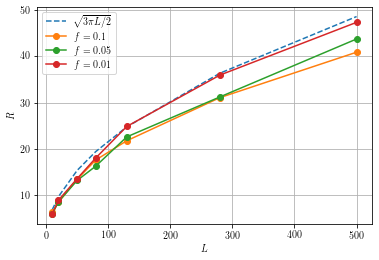

In [16]:
plt.figure()
plt.xlabel("$L$")
plt.ylabel("$R$")
plt.grid()
rlist = [R_f01, R_f005, R_f001]
plt.plot(L_val, TheoreticalScaling(L_val), '--', label='$\sqrt{3\pi L/2}$')
for r in range(3):
    plt.plot(L_val, rlist[r], 'o-', label='$f = '+str(f_val[r])+'$') 
plt.legend()
plt.savefig('symmetricSM.pdf', bbox_inches='tight')
plt.show()